# A Basic Pedometer

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.signal import find_peaks

In [2]:
def extractIMU(df):
    #extract accelerometer Z data from df
    #structure is rtcDate,rtcTime,aX,aY,aZ,gX,gY,gZ,mX,mY,mZ,imu_degC,output_Hz,
    accZdata=df.loc[:,'aZ'].values/100
    
    #freq drifts, so an average reading is good enough
    dt = 1/(np.mean(df.loc[:,'output_Hz'].values))
    time=np.arange(0, len(df), 1, float)*dt
    
    return accZdata, time

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def analyzeAccz(df, maw, height):
    
    [accZdata, time] = extractIMU(df)
    
    #assuming phone is flat, simply average accZ data for offset (gravity)
    #only shown as a formality, extraction of gravity is only required if phone tilts
    accZ=accZdata-np.mean(accZdata)
    
    #smooth data with moving average
    accZma = moving_average(accZ, maw)
    #locate peaks, which are the "steps"
    peaks, _ = find_peaks(accZma, height)
    
    return accZ, accZma, time, peaks

def plotpeaks(time, accz, acczma, peaks, maw, lmin, lmax):
    plt.rcParams['figure.figsize'] = [12, 6]

    fig=plt.figure()
    plt.plot(time,accz , label="Raw Data")
    plt.plot(time[0:-(maw-1)],acczma, label="Filtered Data")
    plt.plot(time[peaks], acczma[peaks], "r.", markersize=20, label="Detected Peaks")
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration (m/s$^2$)')
    plt.title('Z Accelerometer Data')
    plt.xlim([lmin, lmax])
    plt.legend()
    
def filterpeaks(time, peaks):
    peaks_f=[]
    # Humans walks at 1 - 2.5 Hz. If peaks are detected closer than 0.4 s discard one of them
    for i in range(len(time[peaks])-1):
        if time[peaks[i+1]]-time[peaks[i]] >= 0.4:
            peaks_f=np.append(peaks_f, peaks[i+1])

    peaks_f=peaks_f.astype(int)

    return peaks_f

def steplength(peaks_f, time):
    #Emperical step length (SL) model
    a=0.371
    b=0.227
    c=1
    H=1.80 #my height
    SF=np.mean(1/(np.diff(time[peaks_f]))) #Step frequency as an average from dataset

    SL=(0.7 + a*(H-1.75)+b*(SF-1.79)*H/(1.75))*c
    return SL

# Read accelerometer data

In [3]:
df=pd.read_csv('basic_pedometer_data.txt', sep=',',header=0)

# Filter data, count peaks (steps), and plot

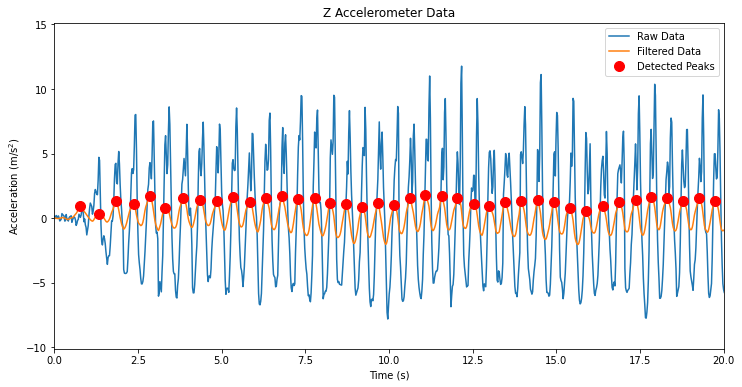

In [4]:
maw=30
accz, acczma, time, peaks = analyzeAccz(df, maw, None)
peaks_f = filterpeaks(time, peaks)
plotpeaks(time, accz, acczma, peaks_f, maw, 0, 20)

# Walking Distance Estimate

In [5]:
#estimate the step length from emperical model
SL = steplength(peaks_f, time)

#total distance = number of steps * step length
distance=len(peaks_f)*SL
distance

150.6578720194376